## SentimentClassifierCNN-LSTM : Reddit Sentiment Analysis Report

#### Hemant Thapa

#### 1. Loading Libraries 

In [1]:
import io
import re
import nltk
import emoji
import string
import pickle
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
importlib.reload(string)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from tabulate import tabulate
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Attention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

#### 2. Loading DataSet 

In [2]:
df = pd.read_csv("Reddit_Data.csv")
df[:5]

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


#### 3. Pre Processing 

In [3]:
print(df[:5].to_string(index=False))

In [4]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37149 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37149 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 870.7+ KB


In [8]:
df.shape

(37149, 2)

In [9]:
df.size

74298

In [10]:
df.category.value_counts()

category
 1    15830
 0    13042
-1     8277
Name: count, dtype: int64

- 0 Indicating it is a neutral sentiment
- 1 Indicating a postive sentiment
- -1 Indicating a negative sentiment

In [11]:
df['sentiment'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

In [12]:
df[:5]

,clean_comment,category,sentiment
0,family mormon have never tried explain them t...,1,Positive
1,buddhism has very much lot compatible with chr...,1,Positive
2,seriously don say thing first all they won get...,-1,Negative
3,what you have learned yours and only yours wha...,0,Neutral
4,for your own benefit you may want read living ...,1,Positive


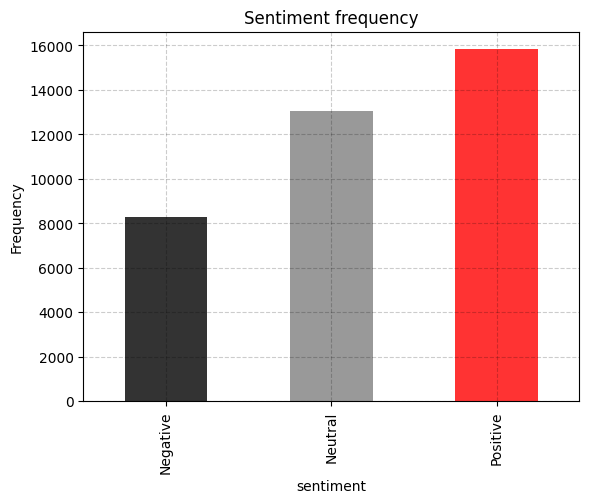

In [13]:
df.groupby('sentiment').size().plot(kind='bar', alpha=0.8, color={'red', 'grey', 'black'})
plt.ylabel("Frequency")
plt.title('Sentiment frequency')
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.show()

In [14]:
# importing unicode_range.py file and list 
from unicode_range import unicode_range

In [15]:
# contractions dictionary
contractions_dict = {
    "can't": "cannot",
    "can\'t": "cannot",
    "n't": " not",
    "n\'t": " not",
    "'re": " are",
    "’re": " are",
    "'s": " is",
    "’s": " is",
    "'d": " would",
    "’d": " would",
    "'ll": " will",
    "’ll": " will",
    "'t": " not",
    "’t": " not",
    "'ve": " have",
    "’ve": " have",
    "'m": " am",
    "’m": " am",
    "I'm": "I am",
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "cannot": "can not",
    "could've": "could have",
    "might've": "might have",
    "must've": "must have",
    "should've": "should have",
    "would've": "would have",
}

In [16]:
def preprocess_text(text):
    # function to remove emojis
    def remove_emoji(text, unicode_ranges):
        emoji_pattern = re.compile(f"[{''.join(unicode_ranges)}]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # function to expand contractions
    def expand_contractions(text, contractions_dict):
        contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

        def replace(match):
            return contractions_dict[match.group(0)]

        return contractions_re.sub(replace, text)

    # F=function to remove multiple consecutive spaces
    def remove_mult_spaces(text):
        return re.sub(r'\s+', ' ', text).strip()

    # function to remove symbols, hashtags, and punctuation
    def removing_symbols(text):
        text_without_hashtags = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
        text_without_underscores = " ".join(word.strip() for word in re.split('#|_', text_without_hashtags))
        cleaned_text = re.sub(r'[!?]', '', text_without_underscores)
        return cleaned_text

    # function to filter out words containing '$' or '&'
    def filter_char(text):
        filtered_words = [word for word in text.split() if '$' not in word and '&' not in word]
        return ' '.join(filtered_words)

    # remove emojis
    text = remove_emoji(text, unicode_range)
    # expand contractions
    text = expand_contractions(text, contractions_dict)
    # normalise whitespace and lowercase the text
    text = text.replace('\r', '').replace('\n', ' ').lower()
    # remove URLs, non-ASCII characters, and numbers
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    non_ascii_pattern = re.compile(r'[^\x00-\x7f]')
    number_pattern = re.compile(r'[0-9]+')
    text = url_pattern.sub('', text)
    text = non_ascii_pattern.sub('', text)
    text = number_pattern.sub('', text)
    # remove punctuation using translate
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove symbols, hashtags, and punctuation
    text = removing_symbols(text)
    # filter out words containing '$' or '&'
    text = filter_char(text)
    # remove multiple consecutive spaces
    text = remove_mult_spaces(text)

    return text

In [17]:
df['cleaned_text'] = df['clean_comment'].apply(preprocess_text)

In [18]:
df.drop(columns='clean_comment', inplace=True)

In [19]:
df[:5]

,category,sentiment,cleaned_text
0,1,Positive,family mormon have never tried explain them th...
1,1,Positive,buddhism has very much lot compatible with chr...
2,-1,Negative,seriously don say thing first all they won get...
3,0,Neutral,what you have learned yours and only yours wha...
4,1,Positive,for your own benefit you may want read living ...


In [20]:
# first 20 comments
for i in range(20):
    print(df['cleaned_text'][i])

family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches
buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basically adv

In [21]:
# tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [22]:
# word index
word_index = tokenizer.word_index

In [23]:
train_texts, test_texts, train_labels, test_labels = train_test_split( df['cleaned_text'], 
                                                                       df['category'], 
                                                                       test_size=0.2, 
                                                                       random_state=101)

In [24]:
(train_texts.shape, train_labels.shape), (test_texts.shape, test_labels.shape)

(((29719,), (29719,)), ((7430,), (7430,)))

In [25]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(train_texts)

# texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# pad the sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=100)  
test_padded = pad_sequences(test_sequences, maxlen=100)

In [26]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') 
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('improved_model_v2.h5', save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [28]:
train_labels_adjusted = train_labels + 1  
test_labels_adjusted = test_labels + 1

history = model.fit(
    train_padded, 
    train_labels_adjusted, 
    epochs=20,  
    batch_size=64,  
    validation_data=(test_padded, test_labels_adjusted), 
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
464/465 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.7015
Epoch 1: val_loss improved from inf to 0.44562, saving model to improved_model_v2.h5
465/465 [==============================] - 29s 47ms/step - loss: 0.6780 - accuracy: 0.7015 - val_loss: 0.4456 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 2/20
465/465 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8813
Epoch 2: val_loss improved from 0.44562 to 0.27304, saving model to improved_model_v2.h5
465/465 [==============================] - 20s 43ms/step - loss: 0.3358 - accuracy: 0.8813 - val_loss: 0.2730 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 3/20
465/465 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9404
Epoch 3: val_loss improved from 0.27304 to 0.25476, saving model to improved_model_v2.h5
465/465 [==============================] - 23s 48ms/step - loss: 0.1938 - accuracy: 0.9404 - val_loss: 0.2548 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 4/20


In [29]:
test_loss, test_acc = model.evaluate(test_padded, test_labels_adjusted)
print('Test Accuracy:', test_acc)

233/233 [==============================] - 2s 9ms/step - loss: 0.3184 - accuracy: 0.9168
Test Accuracy: 0.91682368516922


In [30]:
y_pred = model.predict(test_padded)

233/233 [==============================] - 3s 9ms/step


#### Post Processing 

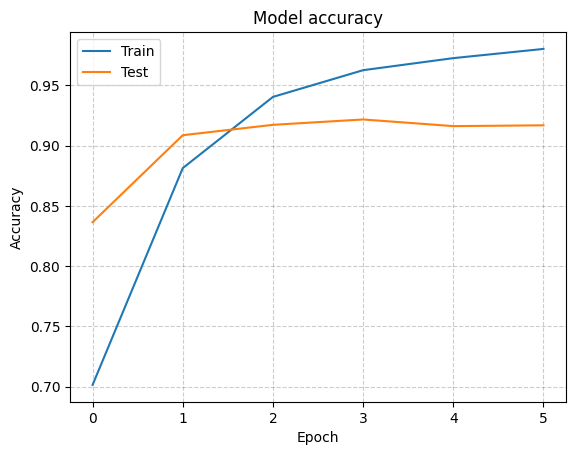

In [31]:
# training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

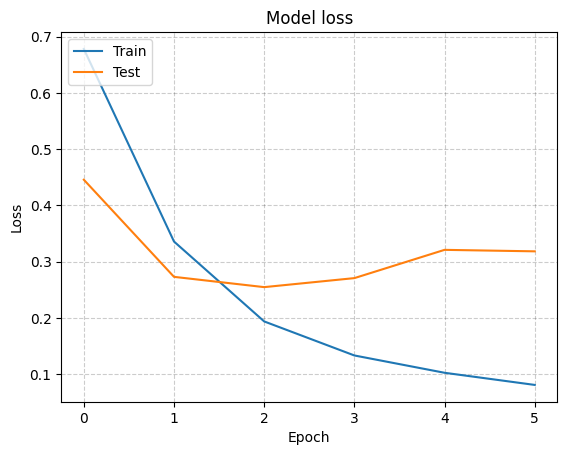

In [32]:
# training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Cloud Plot 

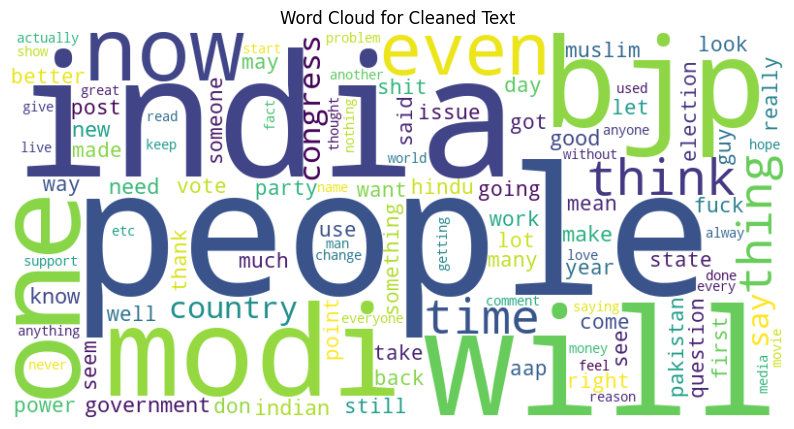

In [33]:
text_combined = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap='viridis', 
                      stopwords=None, min_font_size = 10).generate(text_combined)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cleaned Text')
plt.axis('off')
plt.show()

#### Confusion Matrix 

233/233 [==============================] - 2s 8ms/step


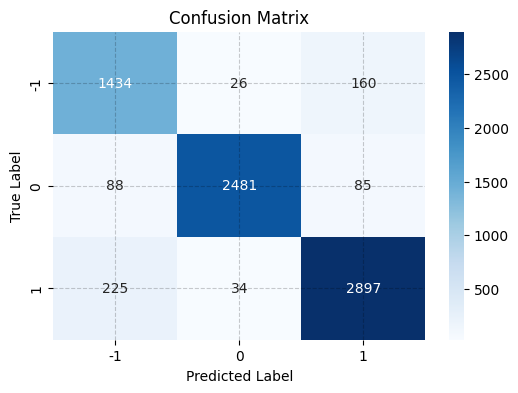

In [34]:
# predict probabilities for the test data
predicted_probabilities = model.predict(test_padded)

# probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(test_labels_adjusted, predicted_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### ROC Curve 

233/233 [==============================] - 2s 8ms/step


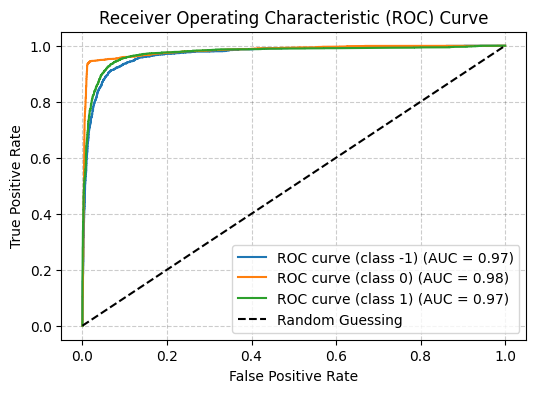

In [35]:
# probabilities for each class
predicted_probabilities = model.predict(test_padded)
# ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve((test_labels_adjusted == i).astype(int), predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC curve for each class
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.legend(loc='lower right')
plt.show()

In [36]:
report = classification_report(test_labels_adjusted, predicted_labels, target_names=['-1', '0', '1'])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.89      0.85      1620
           0       0.98      0.93      0.96      2654
           1       0.92      0.92      0.92      3156

    accuracy                           0.92      7430
   macro avg       0.91      0.91      0.91      7430
weighted avg       0.92      0.92      0.92      7430



In [37]:
# sentiment categories
int_to_sentiment = {
    -1: 'Negative',
    0: 'Neutral',
    1: 'Positive'
}

#### Making Predictions 

In [38]:
# function to preprocess and predict the sentiment
def predict_sentiment(text, tokenizer, model):
    preprocessed_text = preprocess_text(text)  
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded = pad_sequences(sequence, maxlen=100, padding='post')
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction) - 1  
    return int_to_sentiment[predicted_class], preprocessed_text

# iterate over each category and predict sentiment for 5 samples
categories = [-1, 0, 1]
for category in categories:
    print(f"Testing category: {category}")
    samples = df[df['category'] == category]['cleaned_text'][:10]  
    for idx, sample in enumerate(samples):
        predicted_sentiment, cleaned_text = predict_sentiment(sample, tokenizer, model)
        print(f"Sample {idx+1}: Text: '{cleaned_text}'")
        print(f"Predicted Sentiment: '{predicted_sentiment}'")
        print()

Testing category: -1
1/1 [==============================] - 0s 29ms/step
Sample 1: Text: 'seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg'
Predicted Sentiment: 'Negative'

1/1 [==============================] - 0s 29ms/step
Sample 2: Text: 'you should all sit down together and watch the simpsons episode where lisa becomes buddhist simpsons season episode she little faith then discuss'
Predicted Sentiment: 'Negative'

1/1 [==============================] - 0s 26ms/step
Sample 3: Text: 'there are two varieties christians dogmatic that dwell words and conservative that take heart the 

#### References

- [NN-SVG: Neural Network SVG Drawer](https://alexlenail.me/NN-SVG/): A tool for visualizing neural network architectures.
- [TensorFlow Keras Text Classification Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification): Tutorial on text classification using TensorFlow's Keras API.
- [TensorFlow Text Classification with RNNs Tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn): Tutorial on text classification using recurrent neural networks in TensorFlow.
